# Introduction 

-  The cost of hospital readmission accounts for a large portion of hospital inpatient services spending. Diabetes is not only one of the top ten leading causes of death in the world, but also the most expensive chronic disease in the United State. Hospitalized patients with diabetes are at higher risk of readmission than those without diabetes. Therefore, reducing readmission rates for diabetic patients has a great potential to reduce medical cost significantly. The objective of this study is to predict the likelihood of a diabetic patient being readmitted. The dataset was obtained from the Center for Machine Learning and Intelligent Systems at University of California, Irvine, and contains over 100,000 attributes and 50 features, such as number of procedures, number of medications, and time spent in hospital etc. After selecting features using Boruta algorithm and balancing data using ROSE (Random Over Sampling Examples), the dataset was split into training and testing with 10-fold cross validation for the analysis. A variety of predictive models were built: Logistic Regression, Decision Tree, Naïve Bayes, and Random Forest. The model comparison algorithm identified that the high-performance Random Forest outperformed the other models, showing the highest accuracy of 73.22%. This study gained tremendous insights about the significance of different attributes, which can be used to provide recommendations to hospitals. 

**Keywords**: Predictive modeling; 30-day readmission; Hospital readmission; Imbalance class; Feature selection; Diabetes;


# Contents
- [Dataset Description](#dd)
- [Dataset Preparation](#dp)
    - Transform data type
    - Deal with the missing value
    - Recoding and collapsing features
    - Categorization
    - Remove the outliers
- [Feature Selection](#fs)
    - Boruta algorithm
- [Analytical Techniques](#at)
    - Split the dataset into training data and test data
    - Data balancing
    - k-Fold Cross-validation
    - Models and evaluation
- [Model Comparison](#mc)
- [Conclusions](#c)

# 1. Dataset Description <a id = 'dd'></a>
* Collected from 130 hospitals in the U.S. during 10 years(1999-2008)
* Contains 101,766 observations and 50 features
* Description and values of the features can be found in [Research Article](https://www.hindawi.com/journals/bmri/2014/781670/tab1/)
* The following table shows a quick overview of the features' name and types<br>
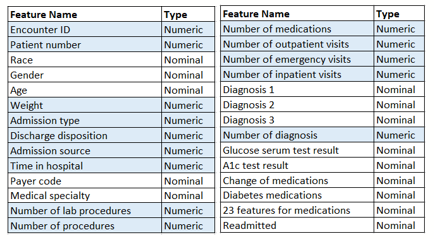

Import libraryies

In [ ]:
library(dplyr)
library(skimr)
library(stringr)
library(psych)
library(ROSE)
library(ggplot2)
library(caret)

In [ ]:
hospData <- read.csv("../input/diabetes/diabetic_data.csv")
skim(hospData)

In [ ]:
#summary(hospData)

# 2. Dataset Preparation <a  id='dp'></a>

## 2.1 Transform data type
Change the data type of **“Admission type”**, **“Discharge disposition”** and **“Admission source”** from numeric to factor. 

In [ ]:
hospData$admission_type_id <- as.factor(hospData$admission_type_id)
hospData$discharge_disposition_id <- as.factor(hospData$discharge_disposition_id)
hospData$admission_source_id <- as.factor(hospData$admission_source_id)

## 2.2 Deal with the missing values


In [ ]:
#count the missing value with mark"?" and "Unknown/Invalid"
count <- 0
for(i in 1:ncol(hospData)){
  if(is.factor(hospData[,i])){
    for(j in 1:nrow(hospData)){
      if(hospData[j,i]== "?" | hospData[j,i]== "Unknown/Invalid" ){
        count <- count + 1
        hospData[j,i] <- NA  #replace "?" and "Unknown/Invalid" values with NA
      }
    }
    if(count > 0){
      print(c(colnames(hospData)[i],count))
    }
  }
  count <- 0
}


In [ ]:
#other method: replace "?" and "Unknown/Invalid"values with NA
# library(naniar)
# replace_with_na_all(data = hospDate, condition = ~.x %in% c("?", "Unknown/Invalid"))

* Due to the large amount of data and long running time, I archive the converted data first for convenience of later call.

In [ ]:
write.csv(hospData, file = "hospData_NA.csv")

In [ ]:
hospD <- read.csv("./hospData_NA.csv")
hospD$X <- NULL

**“Weight”** is missing in over 98% records. **“Payer code”** and **“Medical specialty”** also have 40-50% missing values. The best thing is to drop them because the poor interpretability and little predictive generalizability to patients. 

In [ ]:
#delete columns "weight", "payer_code", "medical_specialty"
hospD$weight <- NULL
hospD$payer_code <- NULL
hospD$medical_specialty <- NULL
dim(hospD)

Remove the **"Encounter ID"** and keep the **"Patient number"**. This is because some patients in the dataset may had more than one encounters and only the patient number is unique. 

In [ ]:
#delete columns "encounter_id"
hospD$encounter_id <- NULL
#delete columns "diag_2", "diag_3", only use the primary diagnosis(diag_1)
hospD$diag_2 <- NULL
hospD$diag_3 <- NULL
dim(hospD)

Two medications named “Citoglipton” and “Examide” were deleted because all records have the same value.

In [ ]:
#"examide" and "citoglipton" only have 1 value, remove
hospD$examide <- NULL
hospD$citoglipton <- NULL
dim(hospD)

In [ ]:
#remove missing value--"race","gender","diag_1"
hospD <- na.omit(hospD)
dim(hospD)

## 2.3 Recoding and collapsing features
### * Example
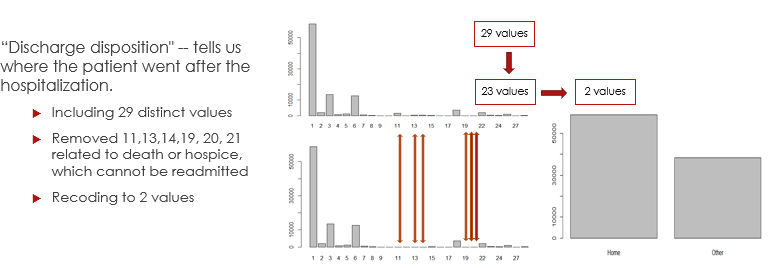

Basing on some common sense:  Since the objective is to predict readmissions, those patients who died during this hospital admission were excluded. Encounters with “Discharge disposition” values of 11, 13, 14, 19, 20, or 21 are related to death or hospice which mean these patients cannot be readmitted. 

In [ ]:
par(mfrow = c(1,2))
barplot(table(hospD$discharge_disposition_id), main = "Before")
#"discharge__disposition_id" tells us where the patient went after the hospitalization.
#11,13,14,19,20,21 related to death or hospice, which cannot be readmitted
#remove
hospD <- hospD[!hospD$discharge_disposition_id %in% c(11,13,14,19,20,21), ]
barplot(table(hospD$discharge_disposition_id), main = "After")

In [ ]:
#change the name of column "admission_type_id" to "admission_type" 
colnames(hospD)[5] <- "admission_type"
barplot(table(hospD$admission_type))

Admission type has 9 values, including emergency, urgent, elective, newborn, and not available.........

In [ ]:
#collapsing some other variable
hospD$admission_type <- replace(hospD$admission_type,hospD$admission_type == 2, 1)
hospD$admission_type <- replace(hospD$admission_type,hospD$admission_type == 7, 1)
hospD$admission_type <- replace(hospD$admission_type,hospD$admission_type == 6, 5)
hospD$admission_type <- replace(hospD$admission_type,hospD$admission_type == 8, 5)

barplot(table(hospD$admission_type), main = "After collapsing")

In [ ]:
#change the name of variables
hospD$admission_type <- str_replace(hospD$admission_type,"1","Emergency")
hospD$admission_type <- str_replace(hospD$admission_type,"5","Other")
hospD$admission_type <- str_replace(hospD$admission_type,"3","Elective")
hospD$admission_type <- str_replace(hospD$admission_type,"4","Newborn")

hospD$admission_type <- as.factor(hospD$admission_type)
barplot(table(hospD$admission_type))

Admission source has 21 values, including physician referral, emergency room, and transfer from a hospital.....

In [ ]:
#change the name of column "admission_source_id" to "admission_source" 
colnames(hospD)[7] <- "admission_source"
barplot(table(hospD$admission_source))

In [ ]:
#collapsing some other variable and change the name of variables
hospD$admission_source <- case_when(hospD$admission_source %in% c("1","2","3") ~ "Physician   Referral",
                                    hospD$admission_source %in% c("4","5","6","8","9","10","11","12","13","14","15","17","18","19","20","21","22","23","24","25","26") ~   "Other",  
                                    TRUE ~ "Emergency Room")                                          

hospD$admission_source <- as.factor(hospD$admission_source)
barplot(table(hospD$admission_source), main = "After collapsing and changing the type")

Discharge disposition has  29 values, for example, discharged to home, expired, and not available......

In [ ]:
#change the name of column "discharge_disposition_id" to "discharge_disposition" 
colnames(hospD)[6] <- "discharge_disposition"
barplot(table(hospD$discharge_disposition))

In [ ]:
#collapsing some other variable and change the name of variables
hospD$discharge_disposition <- case_when(hospD$discharge_disposition %in% "1" ~ "Home",
                                         TRUE ~ "Other")

hospD$discharge_disposition <- as.factor(hospD$discharge_disposition)
barplot(table(hospD$discharge_disposition), main = "After collapsing and changing the type")

## 2.4 Categorization

The **'diag_1'** contained three diagnoses for a given patient (primary, secondary and additional). However, each of these had 700-900 unique ICD codes and it is extremely difficult to include them in the model and interpret them meaningfully. Therefore, these diagnosis codes were collapsed into 9 disease categories, which include Circulatory, Respiratory, Digestive, Diabetes, Injury, Musculoskeletal, Genitourinary, Neoplasms, and Others (See Table below) 
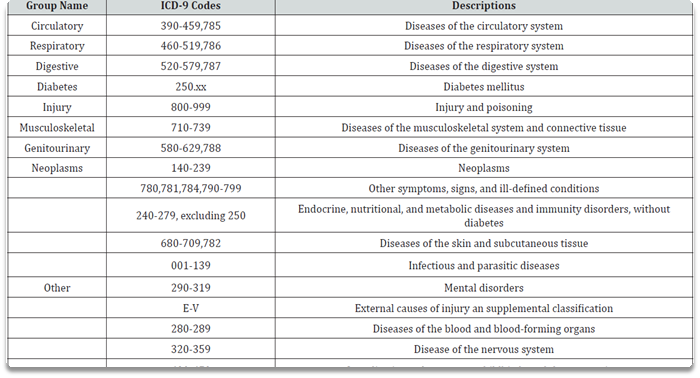

In [ ]:
hospD$diag_1 <- as.character(hospD$diag_1)

hospD<- mutate(hospD, primary_diagnosis =
                                          ifelse(str_detect(diag_1, "V") | str_detect(diag_1, "E"),"Other", 
                                          # disease codes starting with V or E are in “other” category;
                                          ifelse(str_detect(diag_1, "250"), "Diabetes",
                                          ifelse((as.integer(diag_1) >= 390 & as.integer(diag_1) <= 459) | as.integer(diag_1) == 785, "Circulatory",
                                          ifelse((as.integer(diag_1) >= 460 & as.integer(diag_1) <= 519) | as.integer(diag_1) == 786, "Respiratory", 
                                          ifelse((as.integer(diag_1) >= 520 & as.integer(diag_1) <= 579) | as.integer(diag_1) == 787, "Digestive", 
                                          ifelse((as.integer(diag_1) >= 580 & as.integer(diag_1) <= 629) | as.integer(diag_1) == 788, "Genitourinary",
                                          ifelse((as.integer(diag_1) >= 140 & as.integer(diag_1) <= 239), "Neoplasms",  
                                          ifelse((as.integer(diag_1) >= 710 & as.integer(diag_1) <= 739), "Musculoskeletal",          
                                          ifelse((as.integer(diag_1) >= 800 & as.integer(diag_1) <= 999), "Injury",                    
                                          "Other"))))))))))

In [ ]:
#**********************************other method*************************************#
#hospD <-mutate(hospD, primary_diagnosis = case_when (
#                                                   str_detect(diag_1, "V") | str_detect(diag_1, "E") ~ "Other",
#                                                    str_detect(diag_1, "250") ~ "Diabetes",
#                                                    (as.integer(diag_1) >= 390 & as.integer(diag_1) <= 459) | as.integer(diag_1) == 785 ~ "Circulatory",
#                                                    (as.integer(diag_1) >= 460 & as.integer(diag_1) <= 519) |as.integer(diag_1) == 786 ~ "Respiratory", 
#                                                    (as.integer(diag_1) >= 520 & as.integer(diag_1) <= 579) | as.integer(diag_1) == 787~ "Digestive", 
#                                                    (as.integer(diag_1) >= 580 & as.integer(diag_1) <= 629) | as.integer(diag_1) == 788 ~ "Genitourinary", 
#                                                    as.integer(diag_1) >= 140 & as.integer(diag_1) <= 239 ~ "Neoplasms",
#                                                    as.integer(diag_1) >= 710 & as.integer(diag_1) <= 739  ~ "Musculoskeletal", 
#                                                    as.integer(diag_1) >= 800 & as.integer(diag_1) <= 999 ~ "Injury",                    
#                                                    TRUE ~ "other"))

In [ ]:
hospD$primary_diagnosis <- as.factor(hospD$primary_diagnosis)
table(hospD$primary_diagnosis)

In [ ]:
#remove "diag_1"
hospD$diag_1 <- NULL

Regrouping the age.

In [ ]:
barplot(table(hospD$age))

In [ ]:
#regroup the "age" to [0-40],[40-50],[50-60],[60-70],[70-80],[80-100]
hospD$age <- case_when(hospD$age %in% c("[0-10)","[10-20)","[20-30)","[30-40)") ~ "[0-40]",
                       hospD$age %in% c("[80-90)","[90-100)") ~ "[80-100]",
                       hospD$age %in% "[40-50)" ~ "[40-50]",
                       hospD$age %in% "[50-60)" ~ "[50-60]",
                       hospD$age %in% "[60-70)" ~ "[60-70]",
                       TRUE ~ "[70-80]")
barplot(table(hospD$age), main = "Regroup Age")

In [ ]:
hospD$age <- as.factor(hospD$age)

In [ ]:
#rename "A1Cresult" to "HbA1c"
colnames(hospD)[17] <- "HbA1c"

In [ ]:
#remove some features medications, just keep 7 features
hospD$repaglinide <- NULL
hospD$nateglinide <- NULL
hospD$chlorpropamide <-NULL
hospD$acetohexamide <- NULL
hospD$tolbutamide <- NULL
hospD$acarbose <- NULL
hospD$miglitol <- NULL
hospD$troglitazone <- NULL
hospD$tolazamide <- NULL
hospD$glyburide.metformin <- NULL
hospD$glipizide.metformin <- NULL
hospD$glimepiride.pioglitazone <- NULL
hospD$metformin.rosiglitazone <- NULL
hospD$metformin.pioglitazone <- NULL

In [ ]:
dim(hospD)

In [ ]:
#categorize "readmitted" to 1 --patient was readmitted within 30 days, 0-- readmission after 30 days and no readmission
hospD$readmitted <- case_when(hospD$readmitted %in% c(">30","NO") ~ "0",
                              TRUE ~ "1")
hospD$readmitted <- as.factor(hospD$readmitted)
levels(hospD$readmitted)


In [ ]:
#remove patients who had multiple encounters (remove duplicated rows by a column)
hospD <- hospD[!duplicated(hospD$patient_nbr),]
#remove "patient_nbr"
hospD$patient_nbr <- NULL

dim(hospD)

In [ ]:
#archive the converted data first for convenience of later call.
write.csv(hospD, file = "hospD_bef_outlier.csv")

## 2.5 Remove the outliers

In [ ]:
par(mfrow = c(2,4))
boxplot(hospD$time_in_hospital, main = "time_in_hospital")
boxplot(hospD$num_lab_procedures, main = "num_lab_procedures")
boxplot(hospD$num_procedures, main = "num_procedures")
boxplot(hospD$num_medications, main = "num_medications")
boxplot(hospD$number_outpatient, main = "number_outpatient")
boxplot(hospD$number_emergency, main = "number_emergency")
boxplot(hospD$number_inpatient, main = "number_inpatient")
boxplot(hospD$number_diagnoses, main = "number_diagnoses")

In [ ]:
hospD$number_emergency <- NULL
hospD$number_inpatient <- NULL
hospD$number_outpatient <- NULL
dim(hospD)

In [ ]:
#remove the outliers
outliers_remover <- function(a){
  df <- a
  aa <- c()
  count <- 1
  for(i in 1:ncol(df)){
    if(is.integer(df[,i])){
      Q3 <- quantile(df[,i], 0.75, na.rm = TRUE)
      Q1 <- quantile(df[,i], 0.25, na.rm = TRUE) 
      IQR <- Q3 - Q1  #IQR(df[,i])
      upper <- Q3 + 1.5 * IQR
      lower <- Q1 - 1.5 * IQR
      for(j in 1:nrow(df)){
        if(is.na(df[j,i]) == TRUE){
          next
        }
        else if(df[j,i] > upper | df[j,i] < lower){
          aa[count] <- j
          count <- count+1                  
        }
      }
    }
  }
  df <- df[-aa,]
}
hospD <- outliers_remover(hospD)

### Check if there is any multicollinearity between variables. 
(P.S: Correlation coefficient greater than 0.7 means there is multicollinearity between two variables.)


In [ ]:
pairs.panels(hospD[c("time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_diagnoses")])

In [ ]:
dim(hospD)
table(hospD$readmitted)

## Final dataset
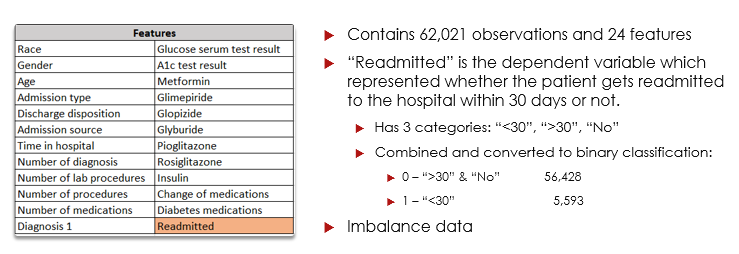

# 3. Feature Selection<a id='fs'></a>
There are three general classes of feature selection algorithms, including filter methods, wrapper methods and embedded methods. I used wrapper methods for this study, using which a subset of different features combinations is selected, prepared, evaluated and compared to other combinations, see figure below 
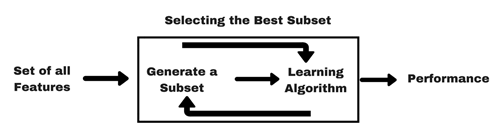

Boruta algorithm as a wrapper method is one of the best ways to execute feature selection that finds relevant features by comparing original features’ importance achievable at random.

In [ ]:
## ensure results are repeatable
#set.seed(100)
## load the library
#library(Boruta)

#boruta <- Boruta(readmitted ~., data = hospD, doTrace = 2)
#plot(boruta, las = 2, cex.axis = 0.5)
#plotImpHistory(boruta)
#attStats(boruta)
#boruta

 > boruta<br>
 Boruta performed 99 iterations in 2.821254 hours.
 18 attributes confirmed important: admission_source, admission_type, age, change,
 diabetesMed and 13 more;
 4 attributes confirmed unimportant: glimepiride, glyburide, pioglitazone, rosiglitazone;
 1 tentative attributes left: glipizide;


* Due to the large amount of data and long long long long running time, I paste the resulte below.<br>
  The results of the feature selection by Boruta algorithm<br>
  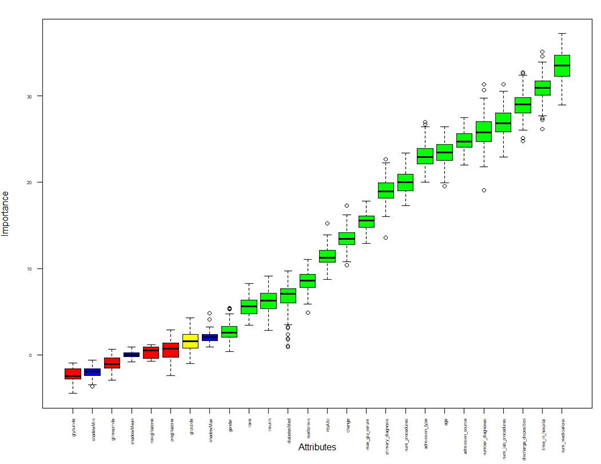


The blue box plot is a measure that include minimum, average and maximum Z score of a shadow feature, while green and red box plots represent features that are important and unimportant, respectively. Yellow box plot indicates tentative features that Boruta is unable to decide whether it is important or not.
* 18 attributes confirmed important
* 4 attributes confirmed unimportant
* 1 tentative attributes left!

In [ ]:
##Tentative Fix
#bor <- TentativeRoughFix(boruta)
#print(bor)

 > print(bor)<br>
Boruta performed 99 iterations in 2.821254 hours.
Tentatives roughfixed over the last 99 iterations.
18 attributes confirmed important: admission_source,
admission_type, age, change, diabetesMed and 13 more;
5 attributes confirmed unimportant: glimepiride, glipizide,
glyburide, pioglitazone, rosiglitazone;

 There are 18 important attributes in this data after feature selection. <br>
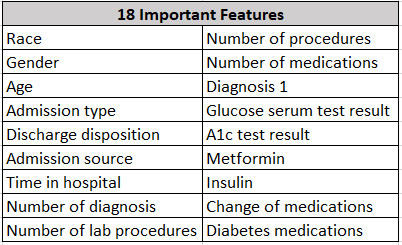

# 4. Analytical Techniques<a id='at'></a>
* 4 Models: Logistic Regression (LR), Decision Trees (DT), Naïve Bayes (NB), Random Forest (RF). 
* Data balancing: undersampling, ROSE
* K-Fold Cross-validation

## 4.1 Split the Dataset into Training Data and Test Data.
Use set.seed(100) as a seed and split the dataset into training and test set with 80:20 proportion, respectively.

In [ ]:
#set random seed
set.seed(100)
train <- createDataPartition(hospD$readmitted, p = 0.8, list = FALSE)
training <- hospD[train, ]
testing <- hospD[-train, ]
#check dependent variable(training set)
table(training$readmitted)

## 4.2 Data balancing
Many studies have shown that the results of balanced data have higher accuracy than imbalanced data. I compare two methods ‘ROSE’ (Random Over Sampling Examples) that uses bootstrapping to increase artificial samples from the feature space neighbor around the minority class 1 (“<30”) and ‘Undersampling’ that reduces the number of observations from majority class 0 (“>30” and “No”) to make the data set balanced. I selected ROSE to balance data set in my study because this method got better accuracy in four machine learning models, see Figure below.

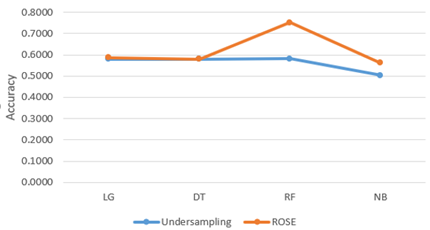<br>
### You can find the sample code in [How to deal with imbalanced data in R?](https://www.kaggle.com/getting-started/190696)

In [ ]:
#balane dataset
data_rose <- ROSE(readmitted ~., data = training)$data
table(data_rose$readmitted)


## 4.3 k-Fold Cross-validation 
Cross-validation is a technique for splitting the data multiple times to get a better estimate of performance metric. K-fold cross-validation is commonly used to reduce the bias associated with the random sampling of the training.

In this study, to estimate the performance of classifier a stratified 10-folds cross-validation algorithm is used. This method of cross-validation splits the data randomly into 10 mutually exclusive equal parts. Nine part is used to train the algorithm and one part to evaluate the algorithm. This process is then executed 10 times by using different training and testing parts. 

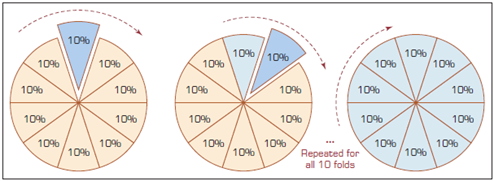

In [ ]:
trCntl <- trainControl(method = "CV",number = 10)

## 4.4 Models and evaluation
### 4.4.1 Logistic regression model with 10-folds cross validation


In [ ]:
logitMod_CV <- train(readmitted ~ race + gender + age + admission_type + discharge_disposition + admission_source + 
                     time_in_hospital + num_lab_procedures + num_procedures + num_medications + number_diagnoses + 
                     max_glu_serum + HbA1c + metformin + insulin + change + diabetesMed + primary_diagnosis, 
                     data = data_rose, trControl = trCntl, method = "glm", family = "binomial")

In [ ]:
logit_pred_CV <- predict(logitMod_CV, testing)

In [ ]:
confusionMatrix(logit_pred_CV, testing$readmitted)

### 4.4.2 Decision Tree model with 10-folds cross validation

In [ ]:
DTMod_CV <- train(readmitted ~ race + gender + age + admission_type + discharge_disposition + admission_source + 
                 time_in_hospital + num_lab_procedures + num_procedures + num_medications + number_diagnoses + 
                  max_glu_serum + HbA1c + metformin + insulin + change + diabetesMed + primary_diagnosis, 
                  data = data_rose, trControl = trCntl, method = "rpart")

In [ ]:
DT_pred_CV <- predict(DTMod_CV, testing)

In [ ]:
confusionMatrix(DT_pred_CV, testing$readmitted)

### 4.4.3 Random Forest model with 10-folds cross validation

In [ ]:
#RFMod_CV <- train(readmitted ~ race + gender + age + admission_type + discharge_disposition + admission_source + 
#                  time_in_hospital + num_lab_procedures + num_procedures + num_medications + number_diagnoses + 
#                 max_glu_serum + HbA1c + metformin + insulin + change + diabetesMed + primary_diagnosis, 
#                  data = data_rose, trControl = trCntl, method = "rf")

In [ ]:
#RF_pred_CV <- predict(RFMod_CV, testing)

In [ ]:
#confusionMatrix(RF_pred_CV, testing$readmitted)

### 4.4.4 NaiveBayesa model with 10-folds cross validation

In [ ]:
#NBMod_CV <- train(readmitted ~ race + gender + age + admission_type + discharge_disposition + admission_source + 
#                  time_in_hospital + num_lab_procedures + num_procedures + num_medications + number_diagnoses + 
#                 max_glu_serum + HbA1c + metformin + insulin + change + diabetesMed + primary_diagnosis, 
#                 data = data_rose, trControl = trCntl, method = "nb")

In [ ]:
#NB_pred_CV <- predict(NBMod_CV, testing)

In [ ]:
#confusionMatrix(NB_pred_CV, testing$readmitted)

# 5. Model Comparison<a id='mc'></a>

Performance metrics per algorithm<br>
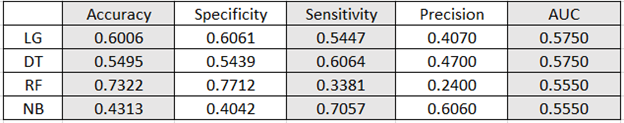


In [ ]:
#model_list <- list(LR = logitMod2_CV, DT = DTMod_CV, RF = RFMod_CV, NB = NBMod_CV)
#res <- resamples(model_list)
#summary(res)

#roc.curve(testing$readmitted, logit_pred2CV, plotit = T, col = "blue")
#roc.curve(testing$readmitted, DT_pred_CV, plotit = T, add.roc = T, col = "red")
#roc.curve(testing$readmitted, NB_pred_CV, plotit = T, add.roc = T, col = "yellow")
#roc.curve(testing$readmitted, RF_pred_CV, plotit = T, add.roc = T, col = "green")

#legend(.8, .4, legend = c("LG", "DT", "NB", "RF"),
#       col = c("blue", "red", "yellow", "green"),
#      lty = c(1,2,3,4), ncol = 1)
#bwplot(res)

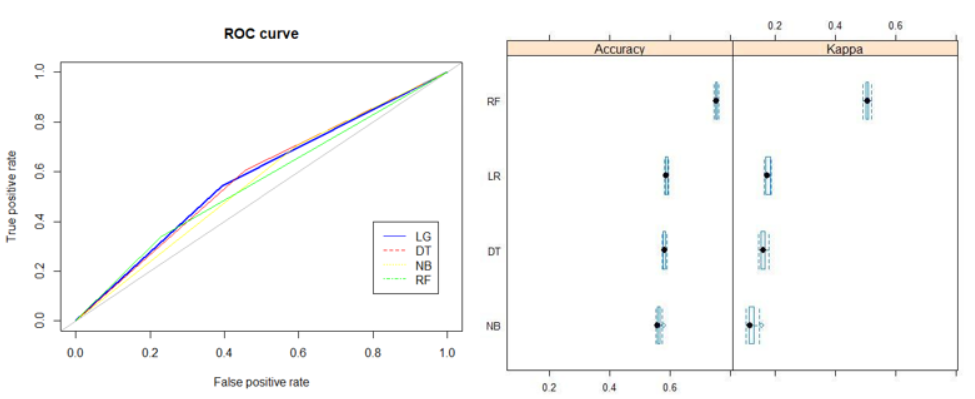

Therefore, Random Forest model performs quite well with this dataset. 

### Variable Importance -- RF!

In [ ]:
#varImp(RFMod_CV)
#ggplot(varImp(RFMod_CV))

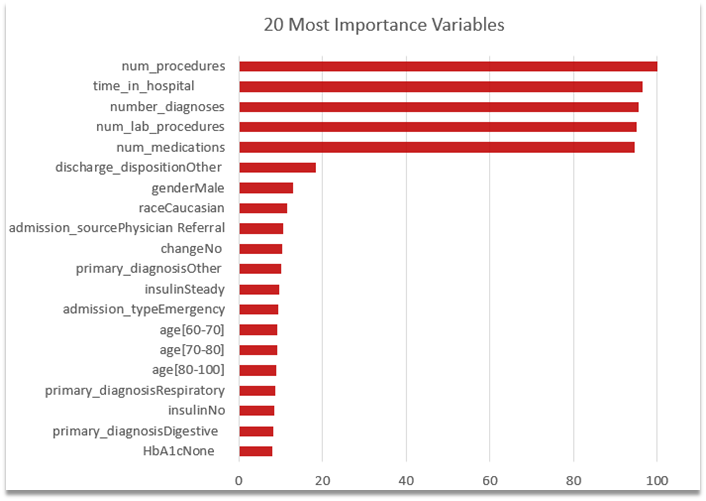

In [ ]:
ggplot(hospD,aes(x=num_procedures,group=readmitted,fill=readmitted))+
  geom_histogram(position="identity",alpha=0.8,binwidth=1)+theme_bw()

In [ ]:
ggplot(hospD,aes(x=time_in_hospital,group=readmitted,fill=readmitted))+
  geom_histogram(position="identity",alpha=0.8,binwidth=1)+theme_bw()

In [ ]:
ggplot(hospD,aes(number_diagnoses,group=readmitted,fill=readmitted))+
  geom_histogram(position="identity",alpha=0.8,binwidth=1)+theme_bw()

In [ ]:
ggplot(hospD,aes(num_lab_procedures,group=readmitted,fill=readmitted))+
  geom_histogram(position="identity",alpha=0.8,binwidth=1)+theme_bw()

In [ ]:
ggplot(hospD,aes(num_medications,group=readmitted,fill=readmitted))+
  geom_histogram(position="identity",alpha=0.8,binwidth=1)+theme_bw()

# 6. Conclusions<a id='c'></a>
-  This study leveraged data that cover demographic, clinical procedure-related and diagnostic-related features, as well as medication information for all ages to build a predictive model in order to identify diabetic patients who have higher likelihood of being readmitted within 30 days. Based on my analysis of four machine learning algorithms, including Logistic Regression, Decision Tree, Random Forest, and Naïve Bayes, in terms of accuracy, Kappa, ROC curve, and confusion matrix, the best model for this purpose has been found to be Random Forest, which yielded an accuracy of 73.22%. Some of the key factors that affect readmission rate are the number of times a patient spent in the hospital, the number of diagnoses, the number of lab procedures and the number of medications. Other not as critical reference information includes admission type, admission source, primary diagnosis, dosage of insulin, value of HbA1c and so on. Based on the results from this study, hospitals are advised to work not only on inpatient treatment but also on continued care after discharge.